# 使用GAN生成Atari游戏画面

本notebook实现了一个生成对抗网络(GAN)，用于生成类似Atari游戏的图像。我们将使用Gymnasium库中的几个Atari游戏环境作为训练数据，然后训练GAN来生成类似的图像。

## 导入必要的库

In [9]:
import cv2
import time
import random
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter

import torchvision.utils as vutils
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

import numpy as np

log = gym.logger
log.set_level(gym.logger.INFO)

## 设置超参数

定义模型训练和生成过程中需要的各种参数。

In [2]:
LATENT_VECTOR_SIZE = 100  # 潜在向量的大小
DISCR_FILTERS = 64        # 判别器中的基础卷积滤波器数量
GENER_FILTERS = 64        # 生成器中的基础卷积滤波器数量
BATCH_SIZE = 16           # 批次大小

# 输入图像将被缩放的尺寸
IMAGE_SIZE = 64

LEARNING_RATE = 0.0001    # 学习率
REPORT_EVERY_ITER = 100   # 每多少次迭代报告一次训练状态
SAVE_IMAGE_EVERY_ITER = 1000  # 每多少次迭代保存一次生成的图像

## 输入预处理包装器

创建一个Gymnasium环境包装器，用于预处理输入图像：
1. 将图像调整为预定义的大小
2. 将颜色通道轴移到第一位置(从HWC格式转为CHW格式)

In [3]:
class InputWrapper(gym.ObservationWrapper):
    """
    输入numpy数组的预处理：
    1. 将图像调整为预定义的大小
    2. 将颜色通道轴移到第一位置
    """
    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        old_space = self.observation_space
        assert isinstance(old_space, spaces.Box)
        self.observation_space = spaces.Box(
            self.observation(old_space.low), self.observation(old_space.high),
            dtype=np.float32
        )

    def observation(self, observation: gym.core.ObsType) -> gym.core.ObsType:
        # 调整图像大小
        new_obs = cv2.resize(
            observation, (IMAGE_SIZE, IMAGE_SIZE))
        # 转换 (w, h, c) -> (c, w, h)
        new_obs = np.moveaxis(new_obs, 2, 0)
        return new_obs.astype(np.float32)

## 判别器模型

判别器网络接收一个图像作为输入，并输出一个表示该图像是真实的(接近1)还是生成的(接近0)的概率值。

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        # 这个管道将图像转换为单个数字
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=DISCR_FILTERS,
                      kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS, out_channels=DISCR_FILTERS*2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 2, out_channels=DISCR_FILTERS * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 4, out_channels=DISCR_FILTERS * 8,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 8, out_channels=1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

## 生成器模型

生成器网络接收一个随机潜在向量作为输入，并生成一个与训练数据相似的图像。

In [5]:
class Generator(nn.Module):
    def __init__(self, output_shape):
        super(Generator, self).__init__()
        # 管道将输入向量反卷积成 (3, 64, 64) 图像
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=GENER_FILTERS * 8,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(GENER_FILTERS * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 8, out_channels=GENER_FILTERS * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 4, out_channels=GENER_FILTERS * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 2, out_channels=GENER_FILTERS,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS, out_channels=output_shape[0],
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)

## 批次迭代器

创建一个函数，从Atari游戏环境中收集观察数据，并将它们组织成批次。

In [7]:
def iterate_batches(envs: tt.List[gym.Env],
                    batch_size: int = BATCH_SIZE) -> tt.Generator[torch.Tensor, None, None]:
    batch = [e.reset()[0] for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)

    while True:
        e = next(env_gen)
        action = e.action_space.sample()
        obs, reward, is_done, is_trunc, _ = e.step(action)
        if np.mean(obs) > 0.01:  # 过滤掉全黑的图像
            batch.append(obs)
        if len(batch) == batch_size:
            batch_np = np.array(batch, dtype=np.float32)
            # 将输入归一化到[-1..1]并转换为张量
            yield torch.tensor(batch_np * 2.0 / 255.0 - 1.0)
            batch.clear()
        if is_done or is_trunc:
            e.reset()

## 设置环境和模型

初始化游戏环境、模型、优化器和TensorBoard写入器。

In [8]:
# 设置设备（CPU或GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建游戏环境
envs = [
    InputWrapper(gym.make(name))
    for name in ('Breakout-v4', 'AirRaid-v4', 'Pong-v4')
]
shape = envs[0].observation_space.shape
print(f"观察空间形状: {shape}")

# 初始化判别器和生成器
net_discr = Discriminator(input_shape=shape).to(device)
net_gener = Generator(output_shape=shape).to(device)

# 设置损失函数和优化器
objective = nn.BCELoss()
gen_optimizer = optim.Adam(params=net_gener.parameters(), lr=LEARNING_RATE,
                           betas=(0.5, 0.999))
dis_optimizer = optim.Adam(params=net_discr.parameters(), lr=LEARNING_RATE,
                           betas=(0.5, 0.999))

# 初始化TensorBoard写入器
writer = SummaryWriter()

使用设备: cuda


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


观察空间形状: (3, 64, 64)


## 训练GAN

训练生成对抗网络，交替更新判别器和生成器。

INFO: 迭代 100 用时 1.39秒: 生成器损失=7.530e+00, 判别器损失=9.329e-02
INFO: 迭代 200 用时 1.35秒: 生成器损失=8.673e+00, 判别器损失=4.656e-02
INFO: 迭代 300 用时 1.35秒: 生成器损失=8.783e+00, 判别器损失=1.110e-02
INFO: 迭代 400 用时 1.35秒: 生成器损失=9.984e+00, 判别器损失=2.287e-03
INFO: 迭代 500 用时 1.40秒: 生成器损失=7.860e+00, 判别器损失=1.482e-01
INFO: 迭代 600 用时 1.37秒: 生成器损失=6.332e+00, 判别器损失=7.478e-03
INFO: 迭代 700 用时 1.36秒: 生成器损失=6.307e+00, 判别器损失=1.847e-02
INFO: 迭代 800 用时 1.43秒: 生成器损失=6.784e+00, 判别器损失=5.961e-03
INFO: 迭代 900 用时 1.35秒: 生成器损失=7.713e+00, 判别器损失=1.826e-02
INFO: 迭代 1000 用时 1.39秒: 生成器损失=7.866e+00, 判别器损失=1.351e-02


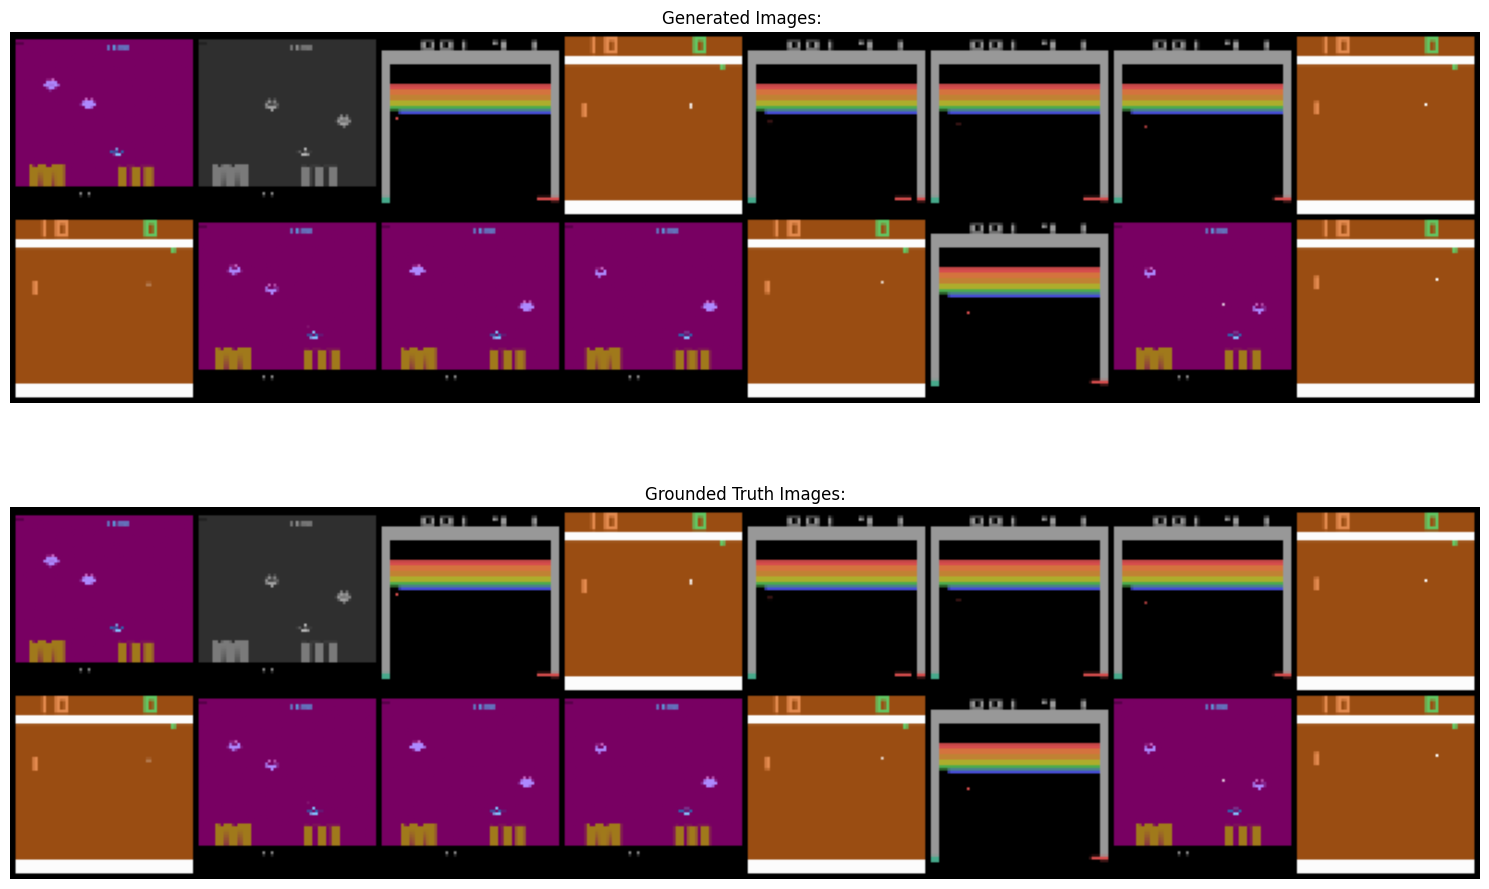

INFO: 迭代 1100 用时 1.63秒: 生成器损失=9.839e+00, 判别器损失=5.027e-02
INFO: 迭代 1200 用时 1.37秒: 生成器损失=8.774e+00, 判别器损失=3.195e-03
INFO: 迭代 1300 用时 1.36秒: 生成器损失=1.506e+01, 判别器损失=1.805e-02
INFO: 迭代 1400 用时 1.34秒: 生成器损失=1.024e+01, 判别器损失=2.926e-02
INFO: 迭代 1500 用时 1.35秒: 生成器损失=7.082e+00, 判别器损失=5.582e-02
INFO: 迭代 1600 用时 1.40秒: 生成器损失=6.543e+00, 判别器损失=5.331e-03
INFO: 迭代 1700 用时 1.43秒: 生成器损失=6.415e+00, 判别器损失=1.449e-01
INFO: 迭代 1800 用时 1.37秒: 生成器损失=6.198e+00, 判别器损失=5.937e-03
INFO: 迭代 1900 用时 1.36秒: 生成器损失=6.981e+00, 判别器损失=5.507e-03
INFO: 迭代 2000 用时 1.35秒: 生成器损失=7.697e+00, 判别器损失=4.867e-02


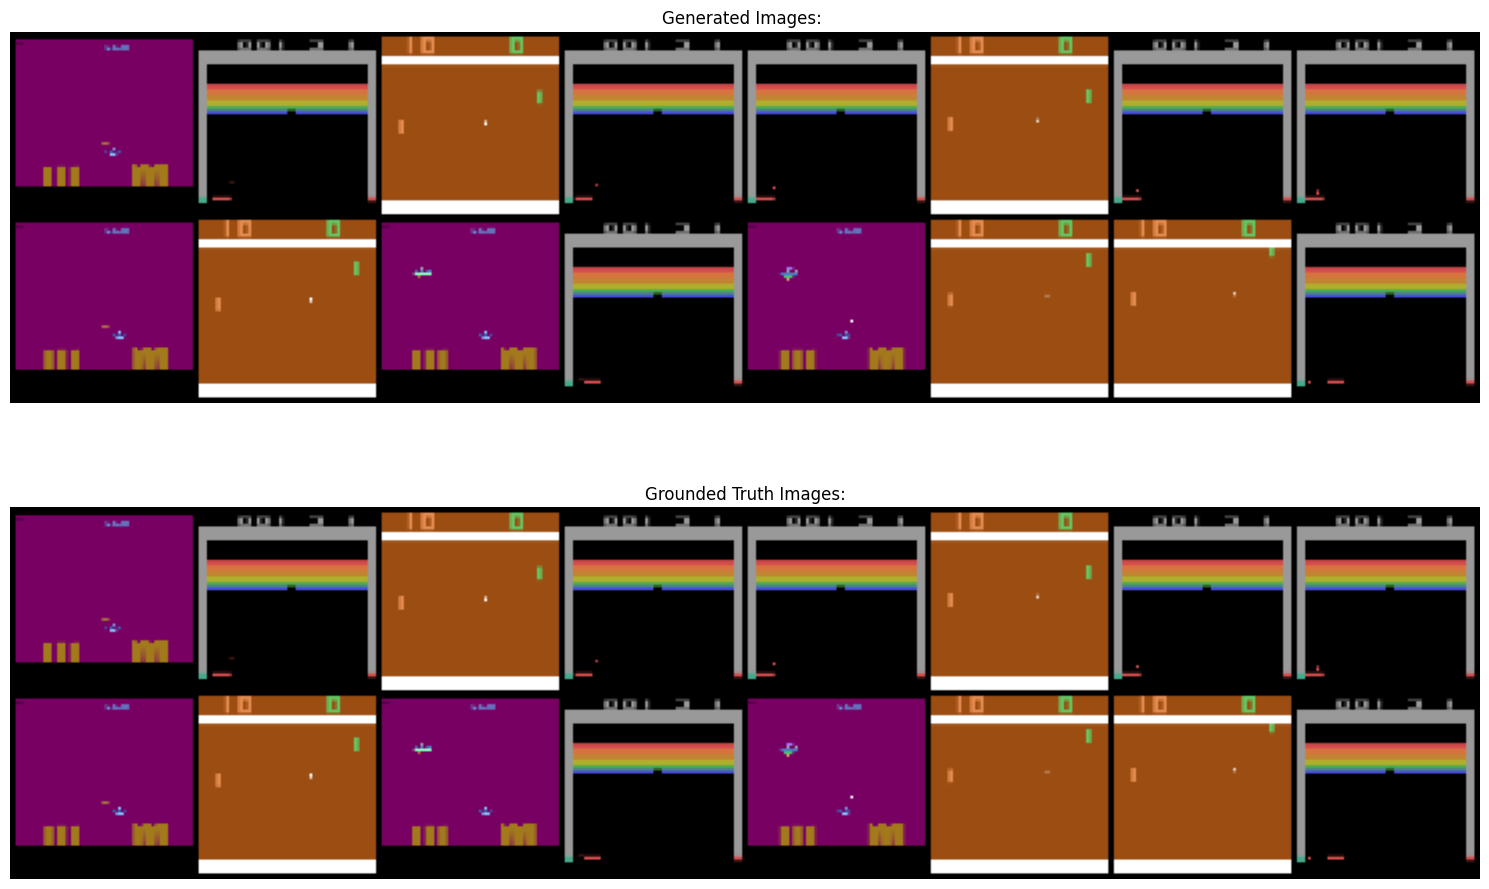

In [18]:
gen_losses = []
dis_losses = []
iter_no = 0

true_labels_v = torch.ones(BATCH_SIZE, device=device)
fake_labels_v = torch.zeros(BATCH_SIZE, device=device)
ts_start = time.time()

# 设置最大迭代次数，可以根据需要调整
max_iterations = 2000

for batch_v in iterate_batches(envs):
    # 生成假样本，输入是4D: batch, filters, x, y
    gen_input_v = torch.FloatTensor(BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1)
    gen_input_v.normal_(0, 1)  # 用正态分布初始化
    gen_input_v = gen_input_v.to(device)
    batch_v = batch_v.to(device)
    gen_output_v = net_gener(gen_input_v)

    # 训练判别器
    dis_optimizer.zero_grad()
    dis_output_true_v = net_discr(batch_v)
    dis_output_fake_v = net_discr(gen_output_v.detach())
    dis_loss = objective(dis_output_true_v, true_labels_v) + \
               objective(dis_output_fake_v, fake_labels_v)
    dis_loss.backward()
    dis_optimizer.step()
    dis_losses.append(dis_loss.item())

    # 训练生成器
    gen_optimizer.zero_grad()
    dis_output_v = net_discr(gen_output_v)
    gen_loss_v = objective(dis_output_v, true_labels_v)
    gen_loss_v.backward()
    gen_optimizer.step()
    gen_losses.append(gen_loss_v.item())

    iter_no += 1
    if iter_no % REPORT_EVERY_ITER == 0:
        dt = time.time() - ts_start
        log.info("迭代 %d 用时 %.2f秒: 生成器损失=%.3e, 判别器损失=%.3e",
                 iter_no, dt, np.mean(gen_losses), np.mean(dis_losses))
        ts_start = time.time()
        writer.add_scalar("gen_loss", np.mean(gen_losses), iter_no)
        writer.add_scalar("dis_loss", np.mean(dis_losses), iter_no)
        gen_losses = []
        dis_losses = []
    if iter_no % SAVE_IMAGE_EVERY_ITER == 0:
        img = vutils.make_grid(gen_output_v.data[:64], normalize=True)
        writer.add_image("fake", img, iter_no)
        img = vutils.make_grid(batch_v.data[:64], normalize=True)
        writer.add_image("real", img, iter_no)
        
        # 显示生成的图像
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.title("Generated Images: ")
        plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        
        plt.subplot(2, 1, 2)
        plt.title("Grounded Truth Images:")
        img_real = vutils.make_grid(batch_v.data[:64], normalize=True)
        plt.imshow(np.transpose(img_real.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # 达到最大迭代次数后停止
    if iter_no >= max_iterations:
        break

## 生成最终样本

使用训练好的生成器生成一些最终样本并显示。

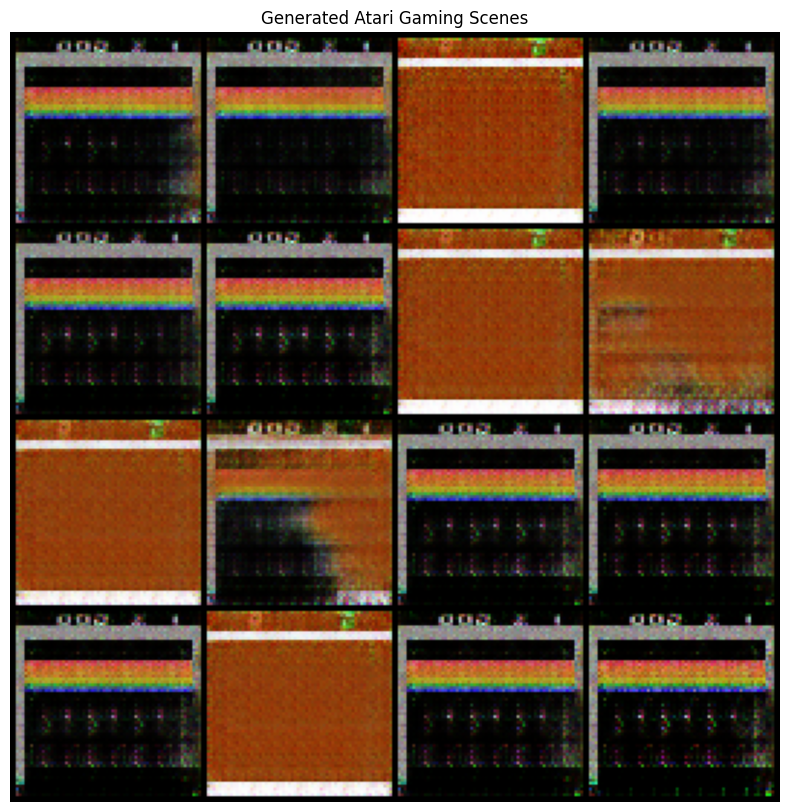

In [20]:
import matplotlib.pyplot as plt

# 生成16个样本
gen_input_v = torch.FloatTensor(16, LATENT_VECTOR_SIZE, 1, 1)
gen_input_v.normal_(0, 1)
gen_input_v = gen_input_v.to(device)

with torch.no_grad():
    gen_output_v = net_gener(gen_input_v)

# 显示生成的图像
plt.figure(figsize=(10, 10))
plt.title("Generated Atari Gaming Scenes")
img = vutils.make_grid(gen_output_v.data, nrow=4, normalize=True)
plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

## 保存模型

保存训练好的生成器和判别器模型，以便将来使用。

In [21]:
# 保存模型
torch.save(net_gener.state_dict(), "atari_generator.pth")
torch.save(net_discr.state_dict(), "atari_discriminator.pth")
print("模型已保存到当前目录")

模型已保存到当前目录


## 关闭TensorBoard写入器和环境

清理资源。

In [22]:
# 关闭TensorBoard写入器
writer.close()

# 关闭环境
for env in envs:
    env.close()

print("训练完成！")

训练完成！
